In [ ]:
!git clone https://github.com/tirthankar95/CSCI_7000_FinalProject.git

Cloning into 'CSCI_7000_FinalProject'...
remote: Enumerating objects: 535, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 535 (delta 18), reused 43 (delta 11), pack-reused 477
Receiving objects: 100% (535/535), 24.74 MiB | 34.01 MiB/s, done.
Resolving deltas: 100% (223/223), done.


In [ ]:
%cd CSCI_7000_FinalProject/gym-minigrid/

/content/CSCI_7000_FinalProject/gym-minigrid


In [ ]:
!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/CSCI_7000_FinalProject/gym-minigrid
     |████████████████████████████████| 8.4 MB 4.7 MB/s 
     |████████████████████████████████| 59.9 MB 1.2 MB/s 
     |████████████████████████████████| 361 kB 78.6 MB/s 
  Running setup.py develop for gym-minigrid


In [ ]:
from gym_minigrid.envs.doorkey import *
from gym_minigrid.envs.crossing import *
from gym_minigrid.envs.mixed import *
#env = CrossingEnv(size=6)
env = MixedEnv(size=8)
env.step_m(1)

/content/CSCI_7000_FinalProject/gym-minigrid/gym_minigrid/roomgrid.py:300: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if front_cell is None or front_cell.type is 'wall':
/usr/local/lib/python3.8/dist-packages/gym/utils/seeding.py:63: DeprecationWarning: WARN: Function `rng.randint(low, [high, size, dtype])` is marked as deprecated and will be removed in the future. Please use `rng.integers(low, [high, size, dtype])` instead.
  deprecation(
/content/CSCI_7000_FinalProject/gym-minigrid/gym_minigrid/minigrid.py:663: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(shape=(grid.width, grid.height), dtype=np.bool)


({'image': array([[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [4, 4, 2]],
  
         [[2, 5, 0],
          [1, 0, 0],
          [1, 0, 0],
          [5, 4, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0]],
  
         [[2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
 

In [ ]:
import gym
import numpy as np
import random
import gym_minigrid
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential,Model
from keras.layers import LSTM,Bidirectional,Dense,Input,Embedding,TimeDistributed
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
num_actions=5

In [ ]:

def plotProgress(reward_plot):
    plt.plot(reward_plot)
    plt.xlabel('Episodes')
    plt.ylabel('Avg. reward')
    plt.title('Avg Reward Per Step V/S Episodes.')
    plt.show()


In [ ]:
frame_offset = 7

In [ ]:
def create():
    global num_actions
    input=Input(shape=(frame_offset+1,147)) # (3,3,7,7) ~ the mini-grid by default returns (3,7,7) image.
    model=LSTM(units=256,return_sequences=False)(input)
    x1 = Dense(units=256, activation='relu')(model)
    x1 = Dense(units=128, activation='relu')(x1)
    x1 = Dense(units=64, activation='relu')(x1)
    x1 = Dense(units=32, activation='relu')(x1)
    x1 = Dense(units=16, activation='relu')(x1)
    output=Dense(units=num_actions,activation='linear')(x1)
    model=Model(input,output)
    return model


In [ ]:
from tqdm import tqdm
global num_actions
# Configuration paramaters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
batch_size = 4096  # Size of batch taken from replay buffer
max_steps_per_episode = 5000 #beast 1000
from gym_minigrid.envs.doorkey import *
from gym_minigrid.envs.crossing import *
from gym_minigrid.envs.mixed import *
env = MixedEnv(size=8)
#env = CrossingEnv(size=6)
#env = gym.make('MiniGrid-DoorKey-6x6-v0')
#env.seed(seed)

model=create()
model_target=create()
loss_function = keras.losses.MeanSquaredError()
optimizer=keras.optimizers.RMSprop()

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
episode_reward_history=[]
done_history = []
reward_plot = []
running_reward = 0
episode_count = 0
frame_count = 0
# Number of frames to take random action and observe output
epsilon_random_frames = 500000 #beast 10000
# Number of frames for exploration
epsilon_greedy_frames = 10000000.0
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 1000000
# Train the model after 4 actions
update_after_actions = 100
# How often to update the target network
update_target_network = 10000
# Using huber loss for stability
# We are taking 3 frames in our LSTM
#frame_offset=2



In [ ]:
termination_steps=[]

In [ ]:
epsilon_greedy_frames = 1000000.0

In [ ]:
noOfEpisodes=200 #beast 100000
#while noOfEpisodes:  # Run until solved
for _ in tqdm(range(noOfEpisodes)):
    #noOfEpisodes-=1
    state = np.array(env.reset_m())
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        # env.render(); Adding this line would show the attempts
        # of the agent in a pop up window.
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            # From environment state
            state_numpy = np.array(state_history[-(frame_offset+1):]).reshape((frame_offset+1),147)
            state_numpy = np.array([state_numpy])
            action_probs = model(state_numpy, training=False)
            # Take best action
            action = np.argmax(action_probs[0])

        # Decay probability of taking random action
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step_m(action)
        state_next = np.array(state_next)

        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        temp_state=dict(state.item(0)) # state is a 0-d numpy array.
        state_history.append(temp_state['image'])
        temp_state=dict(state_next.item(0)) # state is a 0-d numpy array.
        state_next_history.append(temp_state['image'])
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:
            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)-frame_offset), size=batch_size)+frame_offset
            i=indices[0]
            # Using list comprehension to sample from replay buffer
            state_sample = np.array([ np.array(state_history[i-frame_offset:i+1]).reshape((frame_offset+1),147) for i in indices])
            state_next_sample = np.array([ np.array(state_next_history[i-frame_offset:i+1]).reshape((frame_offset+1),147) for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample,verbose=False)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * np.max(\
                future_rewards, axis=1)
            updated_q_values = updated_q_values.astype('float32')
            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)
            with tf.GradientTape() as tape:    
                q_values = model(state_sample)
                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                loss = loss_function(updated_q_values,q_action)
            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]
        if done:
            break

# Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    running_reward = np.mean(episode_reward_history)
    reward_plot.append(episode_reward/timestep)
    episode_count += 1
    termination_steps.append(timestep)
plotProgress(reward_plot)

  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/gym/utils/seeding.py:63: DeprecationWarning: WARN: Function `rng.randint(low, [high, size, dtype])` is marked as deprecated and will be removed in the future. Please use `rng.integers(low, [high, size, dtype])` instead.
  deprecation(
/content/CSCI_7000_FinalProject/gym-minigrid/gym_minigrid/minigrid.py:663: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(shape=(grid.width, grid.height), dtype=np.bool)
 10%|▉         | 19/200 [01:04<08:34,  2.85s/it]

running reward: -1799.78 at episode 2219, frame count 1510000


 22%|██▏       | 43/200 [02:29<08:19,  3.18s/it]

running reward: -1791.87 at episode 2243, frame count 1520000


 32%|███▎      | 65/200 [03:57<12:02,  5.35s/it]

running reward: -1786.12 at episode 2265, frame count 1530000


 46%|████▌     | 91/200 [05:24<06:05,  3.35s/it]

running reward: -1777.69 at episode 2291, frame count 1540000


 57%|█████▋    | 114/200 [06:51<05:06,  3.56s/it]

running reward: -1771.37 at episode 2314, frame count 1550000


 69%|██████▉   | 138/200 [08:21<03:56,  3.81s/it]

running reward: -1764.53 at episode 2338, frame count 1560000


 82%|████████▎ | 165/200 [09:44<01:50,  3.16s/it]

running reward: -1755.08 at episode 2365, frame count 1570000


 90%|█████████ | 180/200 [10:33<00:56,  2.83s/it]

In [ ]:
epsilon

0.8647780599877712

In [ ]:
!rm reward_plot.txt
!rm termination_steps.txt

In [ ]:
a = np.array(reward_plot)
np.savetxt("reward_plot.txt",a)
b = np.array(termination_steps)
np.savetxt('termination_steps.txt',b)

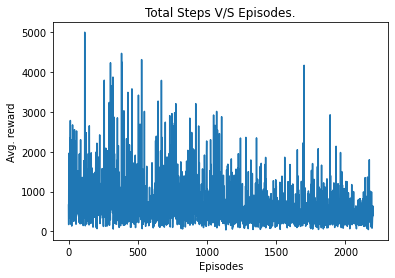

In [ ]:
def plotProgressTimesteps(reward_plot):
    plt.plot(reward_plot)
    plt.xlabel('Episodes')
    plt.ylabel('Avg. reward')
    plt.title('Total Steps V/S Episodes.')
    plt.show()

plotProgressTimesteps(termination_steps)

In [ ]:
env.width

8

In [ ]:
model.save('MixedAgent')

In [ ]:
# import time
# print(model.summary())
# state = np.array(env.reset_m())
# temp_state=dict(state.item(0))
# noOfFrames=3
# state_history=[temp_state['image'] for i in range(noOfFrames)]
# done = False
# i=0
# while not done or i<3000:
#   state_numpy = np.array(state_history[-3:]).reshape(3,147)
#   state_numpy = np.array([state_numpy])
#   action_probs = model(state_numpy, training=False)
#   action = np.argmax(action_probs[0])
#   state, reward, done, _ = env.step_m(action)
#   state=np.array(state)
#   temp_state=dict(state.item(0))
#   del state_history[:1]
#   state_history.append(temp_state['image'])
#   i = i+1
#   if(action>1):
#     print(action,i)
#   #env.render()
#   time.sleep(0.1)


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 3, 147)]          0         
                                                                 
 lstm_6 (LSTM)               (None, 64)                54272     
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dense_10 (Dense)            (None, 5)                 85  

/content/CSCI_7000_FinalProject/Ajay/gym-minigrid/gym_minigrid/minigrid.py:663: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(shape=(grid.width, grid.height), dtype=np.bool)


KeyboardInterrupt: ignored